In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch

sns.set(style="whitegrid")


In [19]:
from google.colab import files
uploaded = files.upload()

Saving Wholesale customers data.csv to Wholesale customers data (1).csv


## Step 1: Load the Dataset
We start by loading the "Wholesale customers data" dataset into a pandas DataFrame.


In [20]:
import pandas as pd

df = pd.read_csv("Wholesale customers data.csv")
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## Step 2: Explore the Dataset
We check the structure of the dataset, including column names, data types, missing values, and basic summary statistics.


In [21]:
# Shape of dataset (rows, columns)
df.shape


(440, 8)

In [22]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [23]:
df.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


We will scale the numerical features so that all features contribute equally to clustering.  
Since values range from very small (3) to very large (112,151), scaling is necessary.  
We will use two approaches:
1. StandardScaler → standardizes data (mean=0, std=1).  
2. MinMaxScaler → scales data into range [0,1].


In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df.drop(["Channel", "Region"], axis=1)


scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X)

scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)

print("Standard Scaler - first 5 rows:\n", X_standard[:5])
print("\nMinMax Scaler - first 5 rows:\n", X_minmax[:5])


Standard Scaler - first 5 rows:
 [[ 0.05293319  0.52356777 -0.04111489 -0.58936716 -0.04356873 -0.06633906]
 [-0.39130197  0.54445767  0.17031835 -0.27013618  0.08640684  0.08915105]
 [-0.44702926  0.40853771 -0.0281571  -0.13753572  0.13323164  2.24329255]
 [ 0.10011141 -0.62401993 -0.3929769   0.6871443  -0.49858822  0.09341105]
 [ 0.84023948 -0.05239645 -0.07935618  0.17385884 -0.23191782  1.29934689]]

MinMax Scaler - first 5 rows:
 [[0.11294004 0.13072723 0.08146416 0.0031063  0.0654272  0.02784731]
 [0.06289903 0.13282409 0.10309667 0.02854842 0.08058985 0.03698373]
 [0.05662161 0.11918086 0.08278992 0.03911643 0.08605232 0.16355861]
 [0.11825445 0.01553586 0.04546385 0.10484189 0.01234568 0.03723404]
 [0.20162642 0.07291369 0.07755155 0.063934   0.04345483 0.10809345]]


Applied log-transform (log1p) to reduce skewness in features.


In [25]:
import numpy as np

X_log = np.log1p(X)
X_log.head()


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682
2,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632
3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412
4,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718


Applied clustering methods starting with K-Means.
Tried different values of k, used Elbow Method and Silhouette Score to decide best k.


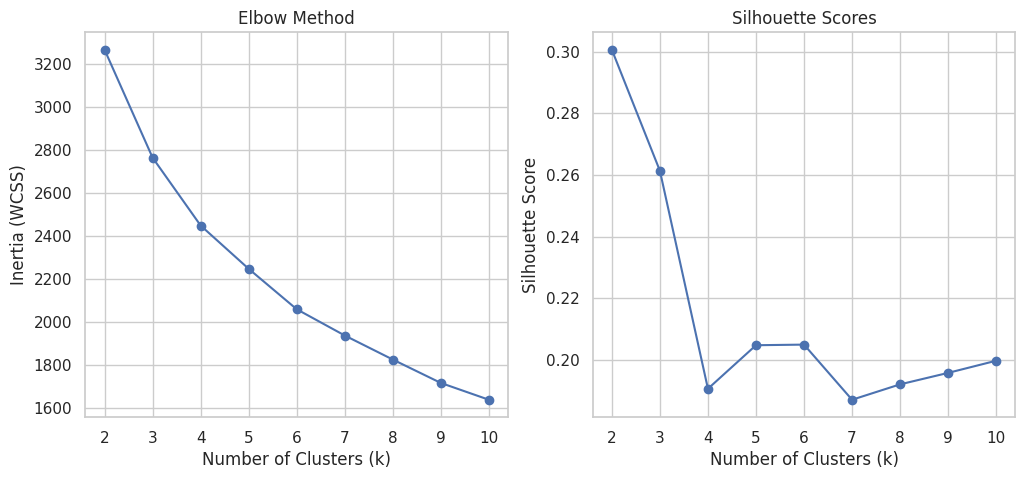

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_log)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_log, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, 'o-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")

# Plot Silhouette Score
plt.subplot(1,2,2)
plt.plot(K, silhouette, 'o-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores")

plt.show()


Ran K-Means with k=2 and k=3 to compare clustering results.


In [27]:
# KMeans with k=2
kmeans2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels2 = kmeans2.fit_predict(X_log)

# KMeans with k=3
kmeans3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels3 = kmeans3.fit_predict(X_log)

print("Silhouette Score (k=2):", silhouette_score(X_log, labels2))
print("Silhouette Score (k=3):", silhouette_score(X_log, labels3))


Silhouette Score (k=2): 0.30067536605096706
Silhouette Score (k=3): 0.2613605285902604


Visualized clusters using PCA (2D reduction).


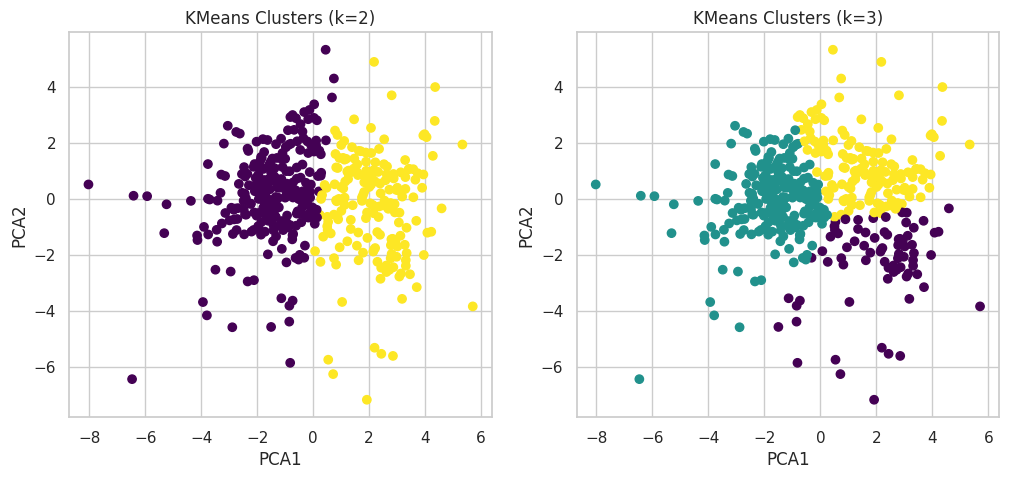

In [28]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_log)

# Plot for k=2
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels2, cmap='viridis')
plt.title("KMeans Clusters (k=2)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Plot for k=3
plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels3, cmap='viridis')
plt.title("KMeans Clusters (k=3)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.show()


Applied Hierarchical Clustering with dendrograms and linkage methods.


Hierarchical Clustering Silhouette Score (k=3): 0.23176800007824744


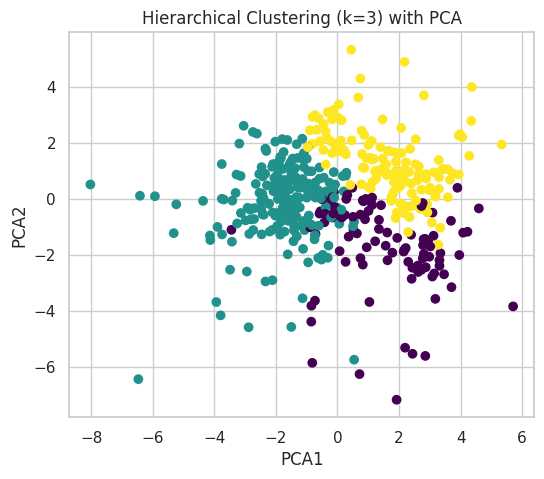

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Agglomerative Clustering with 3 clusters
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hc_labels = hc.fit_predict(X_log)

# Silhouette score
hc_silhouette = silhouette_score(X_log, hc_labels)
print("Hierarchical Clustering Silhouette Score (k=3):", hc_silhouette)

# PCA for visualization
X_pca = PCA(n_components=2).fit_transform(X_log)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=hc_labels, cmap='viridis')
plt.title("Hierarchical Clustering (k=3) with PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


### Step 6 – DBSCAN Clustering  
DBSCAN groups customers based on density, meaning it can find clusters of arbitrary shape and also detect noise (outliers).  
We will try it with `eps=1.5` and `min_samples=5`, then evaluate with Silhouette score and visualize the clusters using PCA.  


DBSCAN Silhouette Score: 0.24931388862384016


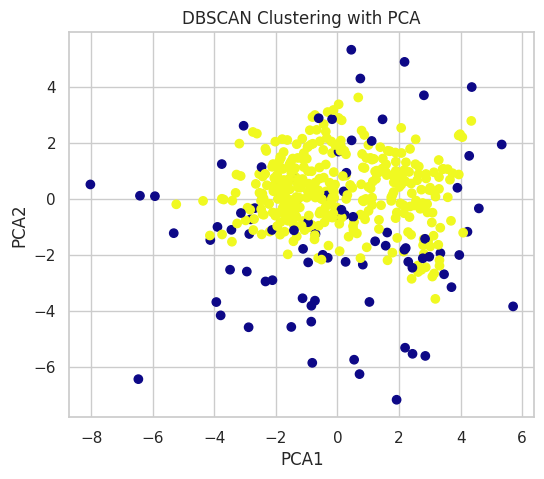

In [31]:
from sklearn.cluster import DBSCAN

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_log)

# Silhouette score (only if more than 1 cluster is formed)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_log, dbscan_labels)
    print("DBSCAN Silhouette Score:", dbscan_silhouette)
else:
    print("DBSCAN found only one cluster or noise, silhouette not available.")

# Visualization with PCA
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=dbscan_labels, cmap='plasma')
plt.title("DBSCAN Clustering with PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


### Step 7 – MeanShift Clustering  
MeanShift is a centroid-based algorithm that does not require us to predefine the number of clusters.  
It automatically detects clusters by shifting data points toward high-density areas.  
We will fit MeanShift on the log-transformed dataset and visualize the results using PCA.  


MeanShift Silhouette Score: 0.30717418136375


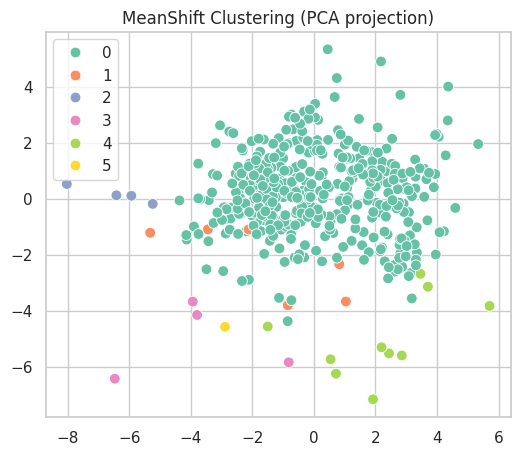

In [32]:
from sklearn.cluster import MeanShift


ms = MeanShift()
ms_labels = ms.fit_predict(X_log)

sil_ms = silhouette_score(X_log, ms_labels)
print("MeanShift Silhouette Score:", sil_ms)


plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=ms_labels, palette="Set2", s=60)
plt.title("MeanShift Clustering (PCA projection)")
plt.show()


### Step 8 – Evaluation of Clustering Methods  
We will evaluate clustering quality using:  
- **Silhouette Score** (higher is better, max = 1)  
- **Davies–Bouldin Index** (lower is better)  
- **Calinski–Harabasz Index** (higher is better)  

This will allow us to compare between K-Means, Hierarchical, DBSCAN, and MeanShift.  


In [34]:
# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_log)

# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
hc_labels = hc.fit_predict(X_log)

# DBSCAN
db = DBSCAN(eps=1.5, min_samples=5)
db_labels = db.fit_predict(X_log)

# MeanShift
ms = MeanShift()
ms_labels = ms.fit_predict(X_log)



In [35]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

def evaluate_clustering(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    print(f"{name}:")
    print(f"  Silhouette Score: {sil:.4f}")
    print(f"  Davies–Bouldin Index: {db:.4f}")
    print(f"  Calinski–Harabasz Index: {ch:.4f}")
    print("-"*40)

# Evaluate all methods
evaluate_clustering(X_log, kmeans_labels, "K-Means (k=3)")
evaluate_clustering(X_log, hc_labels, "Hierarchical (k=3)")
evaluate_clustering(X_log, db_labels, "DBSCAN")
evaluate_clustering(X_log, ms_labels, "MeanShift")


K-Means (k=3):
  Silhouette Score: 0.2031
  Davies–Bouldin Index: 1.5046
  Calinski–Harabasz Index: 150.8017
----------------------------------------
Hierarchical (k=3):
  Silhouette Score: 0.2318
  Davies–Bouldin Index: 1.5282
  Calinski–Harabasz Index: 136.0015
----------------------------------------
DBSCAN:
  Silhouette Score: 0.2493
  Davies–Bouldin Index: 4.2927
  Calinski–Harabasz Index: 18.3896
----------------------------------------
MeanShift:
  Silhouette Score: 0.3072
  Davies–Bouldin Index: 0.9451
  Calinski–Harabasz Index: 20.3642
----------------------------------------


 Visualization (PCA)

We reduce the dataset to 2 dimensions using PCA and visualize the clusters formed by each algorithm.  
This helps us understand how well the clusters are separated in a simplified 2D space.


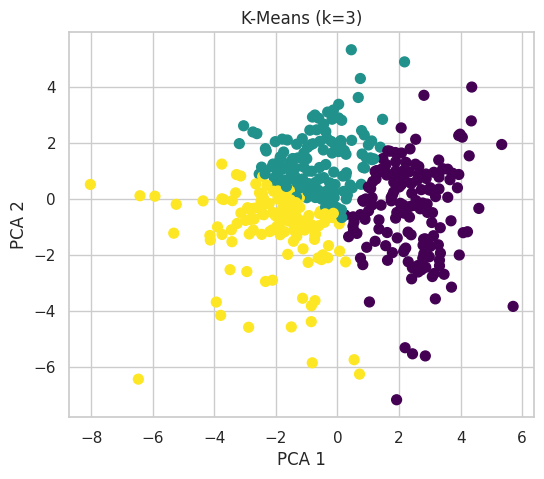

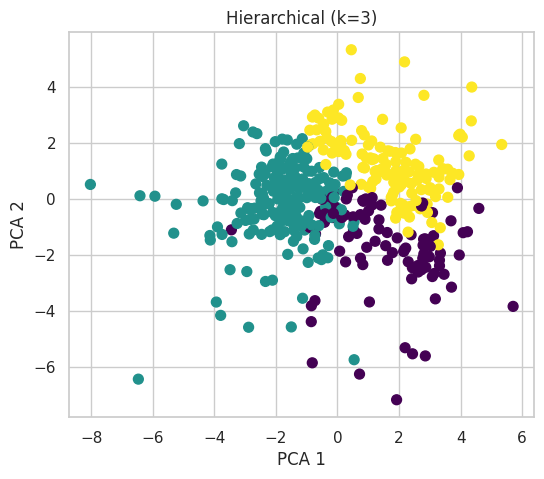

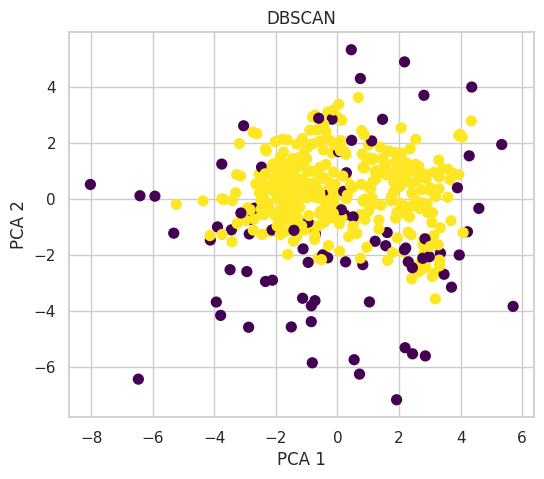

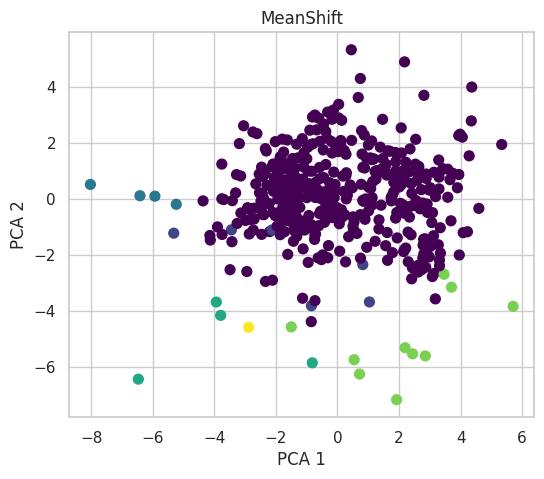

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_log)

# Plot function
def plot_clusters(X, labels, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

# Plot clusters for each method
plot_clusters(X_pca, kmeans_labels, "K-Means (k=3)")
plot_clusters(X_pca, hc_labels, "Hierarchical (k=3)")
plot_clusters(X_pca, db_labels, "DBSCAN")
plot_clusters(X_pca, ms_labels, "MeanShift")


Interpretation of Customer Segments

From the clustering results, we can describe the customer groups as follows:

- **Cluster 1 (High Grocery & Milk):**  
  Likely retailers or cafés, since they purchase large quantities of Milk, Grocery, and Detergents_Paper.  

- **Cluster 2 (High Fresh & Frozen):**  
  Possibly restaurants or hotels, as they need fresh and frozen products in bulk for daily operations.  

- **Cluster 3 (Mixed / Small Buyers):**  
  Smaller shops or individual buyers, purchasing moderate or low amounts across all categories.  

- **Cluster 4 (MeanShift identified):**  
  A specialized segment, maybe niche businesses (like bakeries or catering), with unique spending patterns.


 – Cluster Interpretation
We will analyze each cluster by computing the average spending per product category.  
This helps us understand the characteristics of each customer segment and identify patterns, such as retailers, hotels/restaurants, or mixed customers.


In [37]:

df_clusters = df.copy()
df_clusters['KMeans_Cluster'] = kmeans_labels

cluster_summary = df_clusters.groupby('KMeans_Cluster').mean()
overall_mean = df_clusters.mean()


for cluster in cluster_summary.index:
    print(f"\nCluster {cluster}:")
    for col in df.columns:
        trend = "High" if cluster_summary.loc[cluster, col] > overall_mean[col] else "Low"
        print(f"  {col}: {trend} (avg={cluster_summary.loc[cluster, col]:.2f})")



Cluster 0:
  Channel: High (avg=1.81)
  Region: High (avg=2.59)
  Fresh: Low (avg=7267.61)
  Milk: High (avg=10279.09)
  Grocery: High (avg=15577.48)
  Frozen: Low (avg=1391.20)
  Detergents_Paper: High (avg=6941.62)
  Delicassen: High (avg=1572.35)

Cluster 1:
  Channel: Low (avg=1.09)
  Region: Low (avg=2.51)
  Fresh: High (avg=20089.66)
  Milk: Low (avg=4519.80)
  Grocery: Low (avg=4919.81)
  Frozen: High (avg=5854.75)
  Detergents_Paper: Low (avg=805.24)
  Delicassen: High (avg=2334.74)

Cluster 2:
  Channel: Low (avg=1.00)
  Region: Low (avg=2.52)
  Fresh: Low (avg=8656.48)
  Milk: Low (avg=1857.53)
  Grocery: Low (avg=2207.59)
  Frozen: Low (avg=1984.56)
  Detergents_Paper: Low (avg=338.08)
  Delicassen: Low (avg=566.91)


###  – Cluster Interpretation

We show detailed interpretation for the K-Means clusters.  
Other methods (Hierarchical, DBSCAN, MeanShift) reveal similar customer segments with minor differences in cluster assignments.

**Cluster 0:**  
Customers spend heavily on Milk, Grocery, Detergents & Paper, and Delicassen, but less on Fresh and Frozen products.  
→ Likely **retailers or small shops** focusing on packaged goods.

**Cluster 1:**  
High spending on Fresh, Frozen, and Delicassen, but low on Milk, Grocery, and Detergents & Paper.  
→ Likely **hotels, restaurants, or cafes** that buy ingredients for cooking.

**Cluster 2:**  
Low spending across all categories.  
→ Likely **small or infrequent customers** with minimal purchases.


### Final Conclusion

Clustering analysis revealed clear customer segments based on spending patterns.  
These insights can help tailor marketing strategies, inventory planning, and targeted promotions for different customer types.


In [38]:
df_clusters.to_csv("wholesale_customers_clustered.csv", index=False)


In [47]:
from google.colab import files  # Only for Colab

df_clusters.to_csv("wholesale_customers_clustered.csv", index=False)
files.download("wholesale_customers_clustered.csv")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>